# **Engineer, Generative AI**

## Development of an Adaptable Deep Learning Model for Artistic Style Transfer

### *by Ankit Rajput*

# AIM:

- The aim of this assignment is to create a deep learning model capable of adapting an existing work to resemble the aesthetic of any art. The model should be able to analyze the artistic style of the selected art and apply similar stylistic features to a new, original artwork, creating a piece that seems as though it could have been created by the artist themselves.

## Approach

We are going to implement neural style transfer using the VGG19 model in TensorFlow.
- Neural style transfer is a technique that combines the content of one image with the style of another image. We will use pre-trained VGG19 as a feature extractor and optimizes a third image (initialized with the content image) to minimize the content difference and style difference with the content and style images, respectively.

# **Step: 1**

### Importing important libraries

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models
%matplotlib inline

# **Step: 2**

### data preprocessing

Loading content and style images is a crucial step in neural style transfer applications. The provided load_image function facilitates this process by offering support for various image types and sizes. This function not only loads images but also converts them into normalized Tensors, a format commonly used in deep learning.

Furthermore, for effective style transfer, it is advisable to work with smaller images and ensure that both content and style images are resized to the same dimensions.

In [22]:
def load_image(img_path, max_size=400, shape=None):
    # Load and convert the image to RGB format
    image = Image.open(img_path).convert('RGB')

    # Ensure that the image dimensions are <= 400 pixels in both x and y
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    # Override the size if a specific shape is provided
    if shape is not None:
        size = shape

    # Define a series of transformations using transforms.Compose
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image


In [ ]:
def convert_tensor_to_image(tensor):
    """ Convert a tensor to a NumPy image. """

    # Clone and detach the tensor, move it to the CPU
    image = tensor.to("cpu").clone().detach()

    # Convert the tensor to a NumPy array and rearrange dimensions
    image = image.numpy().squeeze().transpose(1, 2, 0)

    # Undo normalization and clipping to restore original pixel values
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = np.clip(image, 0, 1)

    return image

# **Step: 3**

Model building

In [ ]:
# Obtain the "features" segment of VGG19 (excluding the "classifier" part)
vgg = models.vgg19(pretrained=True).features
# Freeze all parameters of VGG since we're solely optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

In [31]:
# load in content and style image
content = load_image('/content/A-Cat.jpg').to(device)
style = load_image('/content/download.jpg', shape=content.shape[-2:]).to(device)

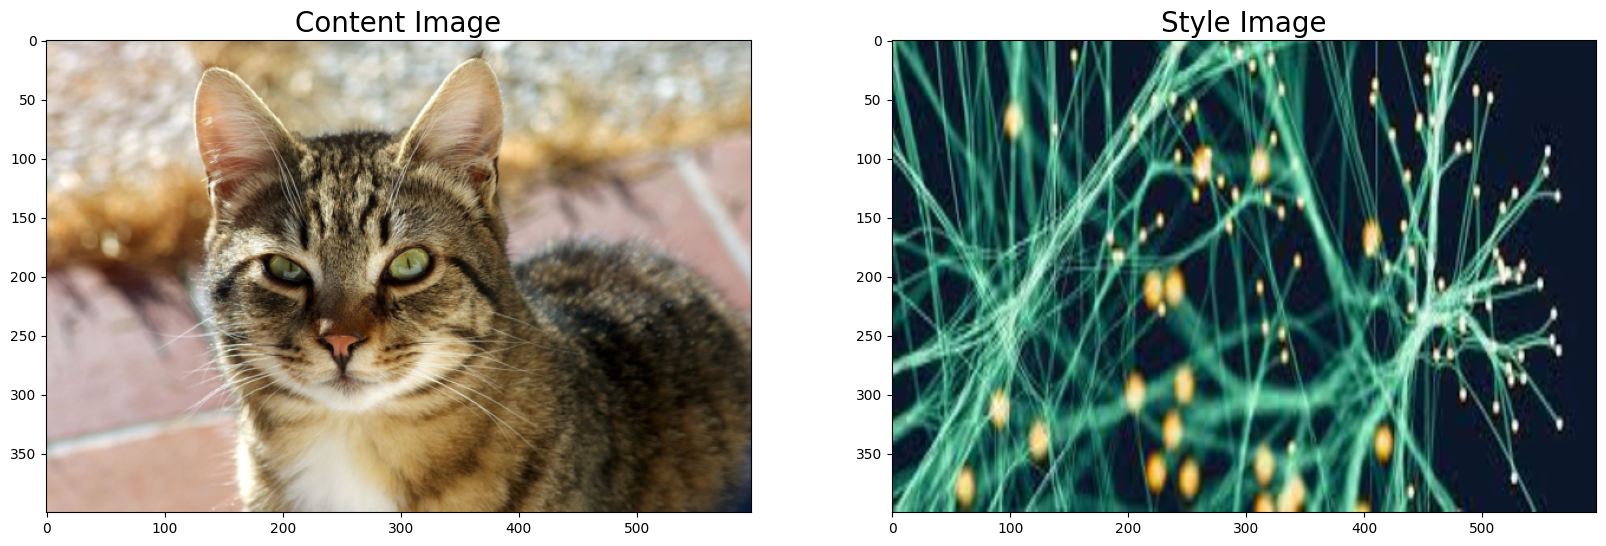

In [25]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(convert_tensor_to_image(content))
ax1.set_title("Content Image",fontsize = 20)
ax2.imshow(convert_tensor_to_image(style))
ax2.set_title("Style Image", fontsize = 20)
plt.show()

---
## Model Architecture

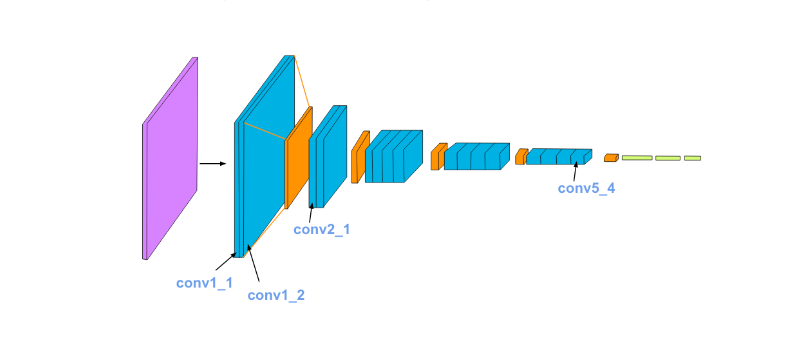






- To obtain the content and style representations of an image, it is necessary to pass an image through the VGG19 network until reaching the desired layer(s) and then extract the output from that layer.


## Content and Style Features

In [28]:
def extract_features(image, model, layers=None):
    """ Forward pass an image through a model and extract features for
        a specified set of layers. Default layers correspond to VGGNet as per Gatys et al. (2016)
    """
    ## Layers needed for content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary containing each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features


---
## Gram Matrix

The output of each convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth `d`, and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be computed as follows:
* Obtain the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size`
* Reshape the tensor so that the spatial dimensions are flattened
* Calculate the Gram matrix by multiplying the reshaped tensor by its transpose


In [29]:
def calculate_gram_matrix(tensor):
    # Get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()

    # Reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)

    # Calculate the Gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram


In [32]:
# get content and style features only once before training
content_features = extract_features(content, vgg)
style_features = extract_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: calculate_gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

## Updating the Target & Calculating Losses

determine the number of steps for updating your image, resembling a training loop. In this case, the focus is solely on modifying the target image without altering VGG19 or any other image. Therefore, the number of steps is flexible and can be set according to your preferences. It is recommended to use at least 2000 steps for optimal results, but you might start with fewer steps for experimentation with weight values or different images.

Within the iteration loop, you will compute the content and style losses and update your target image accordingly.

### Content Loss

The content loss is computed as the mean squared difference between the target and content features at layer `conv4_2`:
```python
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)


# Evaluation

In [37]:
def evaluate(content, style):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # load in content and style image
  content = load_image(content).to(device)
  style = load_image(style, shape=content.shape[-2:]).to(device)

  # Obtain the "features" segment of VGG19 (excluding the "classifier" part)
  vgg = models.vgg19(pretrained=True).features

  # Freeze all parameters of VGG since we're solely optimizing the target image
  for param in vgg.parameters():
      param.requires_grad_(False)


  # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  vgg.to(device)

  # get content and style features only once before training
  content_features = extract_features(content, vgg)
  style_features = extract_features(style, vgg)

  # calculate the gram matrices for each layer of our style representation
  style_grams = {layer: calculate_gram_matrix(style_features[layer]) for layer in style_features}

  # create a third "target" image and prep it for change
  # it is a good idea to start of with the target as a copy of our *content* image
  # then iteratively change its style
  target = content.clone().requires_grad_(True).to(device)


  style_weights = {'conv1_1': 1.,
                  'conv2_1': 0.75,
                  'conv3_1': 0.2,
                  'conv4_1': 0.2,
                  'conv5_1': 0.2}

  content_weight = 1  # alpha
  style_weight = 1e9  # beta


  # for displaying the target image, intermittently
  show_every = 400

  # iteration hyperparameters
  optimizer = optim.Adam([target], lr=0.003)
  steps = 500  # decide how many iterations to update your image (5000)

  for ii in range(1, steps+1):

      # get the features from your target image
      target_features = extract_features(target, vgg)

      # the content loss
      content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

      # the style loss
      # initialize the style loss to 0
      style_loss = 0
      # then add to it for each layer's gram matrix loss
      for layer in style_weights:
          # get the "target" style representation for the layer
          target_feature = target_features[layer]
          target_gram = calculate_gram_matrix(target_feature)
          _, d, h, w = target_feature.shape
          # get the "style" style representation
          style_gram = style_grams[layer]
          # the style loss for one layer, weighted appropriately
          layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
          # add to the style loss
          style_loss += layer_style_loss / (d * h * w)

      # calculate the *total* loss
      total_loss = content_weight * content_loss + style_weight * style_loss

      # update your target image
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
  return target

In [38]:
target = evaluate('/content/content.jpg', '/content/style.jpg')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Final Result

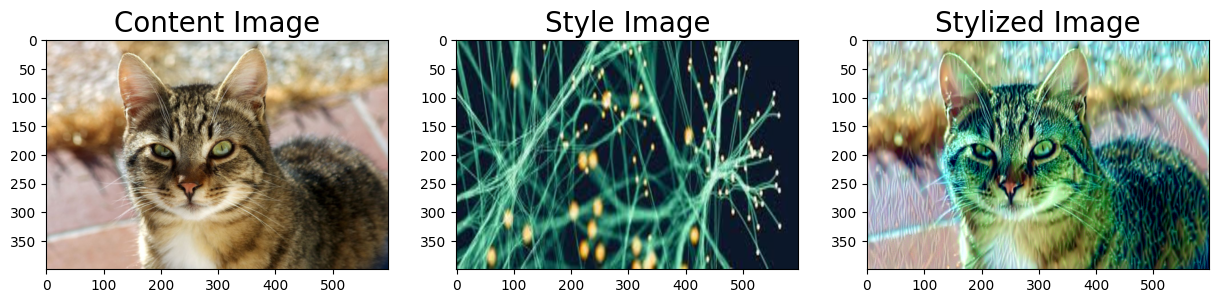

In [41]:
# Display content and final target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(convert_tensor_to_image(content))
ax1.set_title("Content Image", fontsize=20)
ax2.imshow(convert_tensor_to_image(style))
ax2.set_title("Style Image", fontsize=20)
ax3.imshow(convert_tensor_to_image(target))
ax3.set_title("Stylized Image", fontsize=20)
plt.show()